# Electricity Production Forecast using LSTM

## Topic

In the previous notebook I worked on the electricity production dataset with and RNN to try and make forecasts. The results were not so great as the network couldn't capture the highs and lows of the data. In this notebook I will using and LSTM instead, which works with both the long and short term memories and I believe the result will be better than before. So let's get started !

## Objective

- Forecast electricity production using an LSTM

## Summary


- Loading libraries
- The data
- Data plotting 
- Creating the dataset
- Building the model
- Training the model
- Plotting the forecast
- Conclusion

### Loading libraries

In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import preprocessing
from scipy import signal
import torch.utils.data as data

### The Dataset

In [2]:
dataset = pd.read_csv(r'C:\Users\imane\Downloads\archive (22)\Electric_Production.csv', sep =",")
dataset

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151
...,...,...
392,9/1/2017,98.6154
393,10/1/2017,93.6137
394,11/1/2017,97.3359
395,12/1/2017,114.7212


In [3]:
dataset = dataset.rename(columns = {"DATE": "date", "IPG2211A2N": "production"})

In [4]:
dataset["date"] = pd.to_datetime(dataset["date"])

### Data plotting

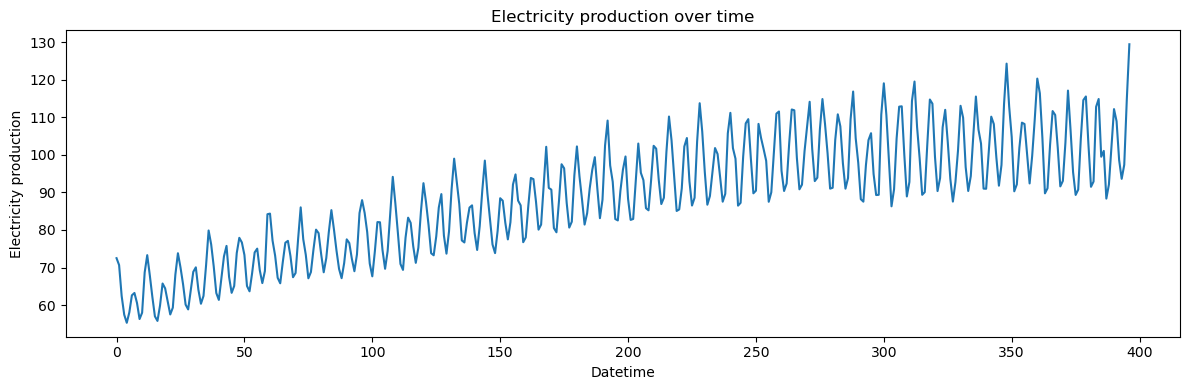

In [5]:
plt.figure(figsize=(12, 4))
plt.plot(dataset['production'])
plt.xlabel('Datetime')
plt.ylabel('Electricity production')
plt.title('Electricity production over time')
plt.tight_layout()
plt.show()

In [6]:
detrended = signal.detrend(dataset.production)
df = pd.DataFrame()
df = df.assign(production = detrended)

In [7]:
data = df[["production"]].values.astype('float32')

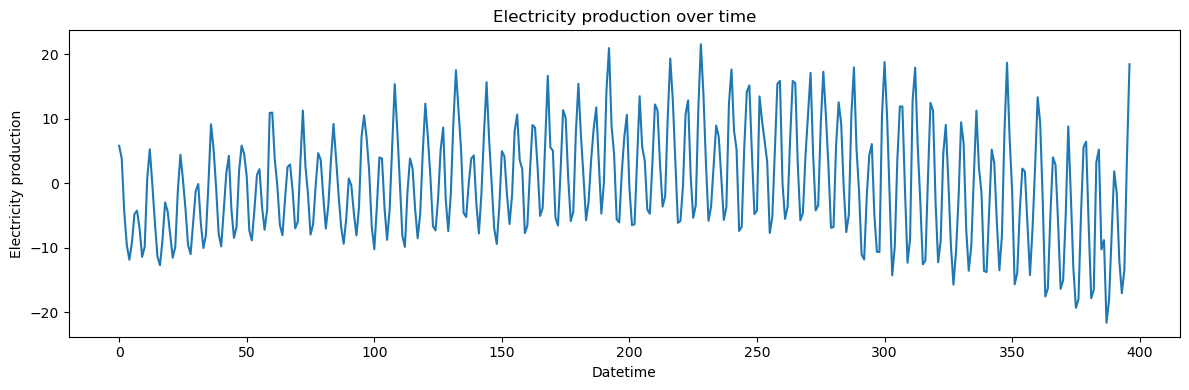

In [8]:
plt.figure(figsize=(12, 4))
plt.plot(df['production'])
plt.xlabel('Datetime')
plt.ylabel('Electricity production')
plt.title('Electricity production over time')
plt.tight_layout()
plt.show()

As in the prvious notebook, I downloaded the data and terned it into time series then detrended it to be fit for the network.

In [9]:
train_size = int(len(df) * 0.72)
test_size = len(df) - train_size
train, test = data[:train_size], data[train_size:]

### Creating the dataset

In [10]:
def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
      
    feature = torch.tensor(X)
    target = torch.tensor(y)
    return feature, target

In [11]:
lookback = 1
X_train, y_train = create_dataset(train, lookback = lookback)
X_test, y_test = create_dataset(test, lookback = lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([284, 1, 1]) torch.Size([284, 1, 1])
torch.Size([111, 1, 1]) torch.Size([111, 1, 1])


C:\Users\imane\AppData\Local\Temp\ipykernel_6244\912132069.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  feature = torch.tensor(X)


The next thing was to define the function that creates the dataset by receiving a sequence as input and producing the output which the input shifted by the lookback steps (1 in this case).

### Building the model

In [12]:
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [13]:
model = LSTM()
print(model)

LSTM(
  (lstm): LSTM(1, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)


In [14]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.1)

In [18]:
test_out = model(X_train)
print(test_out.size())

torch.Size([284, 1, 1])


So I defined a simple non stacked LSTM with input size 1 and 50 hidden features plus a fully connected layer that outputs 1 sequence as well.

### Training the model

In [20]:
n_epochs = 4000
train_loss , test_loss = [], []
for epoch in range(n_epochs):

    model.train
    t_loss = 0.0
    for x in range(len(X_train)):
        
        pred = model(X_train)
        loss = criterion(pred, y_train)
        rmse = np.sqrt(loss.detach().numpy())
        t_loss += rmse
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    
    if epoch% 100 != 0:
        continue
    
    model.eval()
    
    with torch.no_grad():
        #train_p, hidden = model(X_train, hidden)
        #train_rmse = np.sqrt(criterion(train_p, y_train))
        #train_loss.append(train_rmse)
        train_loss.append(t_loss/len(X_train))
        test_p = model(X_test)
        test_rmse = np.sqrt(criterion(test_p, y_test))
        test_loss.append(test_rmse)
        print("epoch", epoch, "train rmse", t_loss/len(X_train), "test rmse", test_rmse)

epoch 0 train rmse 5.8722414030155665 test rmse tensor(9.0907)
epoch 100 train rmse 4.149535812122721 test rmse tensor(11.0692)
epoch 200 train rmse 4.087697403531679 test rmse tensor(12.3346)
epoch 300 train rmse 4.081767362608036 test rmse tensor(12.7249)
epoch 400 train rmse 4.054203156014563 test rmse tensor(13.8440)
epoch 500 train rmse 4.048821664192308 test rmse tensor(14.0057)
epoch 600 train rmse 4.039064320040421 test rmse tensor(14.2615)
epoch 700 train rmse 4.153172116884043 test rmse tensor(13.8479)
epoch 800 train rmse 4.138241008973457 test rmse tensor(13.5701)
epoch 900 train rmse 4.123957397232593 test rmse tensor(13.3068)
epoch 1000 train rmse 4.037385762577325 test rmse tensor(13.0630)
epoch 1100 train rmse 4.03162910568882 test rmse tensor(13.3850)
epoch 1200 train rmse 4.029237763982423 test rmse tensor(13.3509)
epoch 1300 train rmse 4.024154969504182 test rmse tensor(13.1419)
epoch 1400 train rmse 4.0219910379866475 test rmse tensor(13.1243)
epoch 1500 train rmse 

The training happened over 4000 epochs and I printed the train and test errors every 100 epochs. It looks like the training loss decreases slightly throughout the process, but the testing error increases which suggests that the model might be overfitting.

### Plotting the forecast

In [21]:
def plot_forecast(forecast, model):
    plt.figure(figsize=(12,4))
    #plt.plot(X_train.squeeze(-1), label='Training')
    plt.plot(X_test.squeeze(-1), label='Actual')
    plt.plot(forecast, label='Forecast')
    plt.xlabel('Datetime')
    plt.ylabel('electricity production')
    plt.legend()
    plt.tight_layout()
    plt.show()

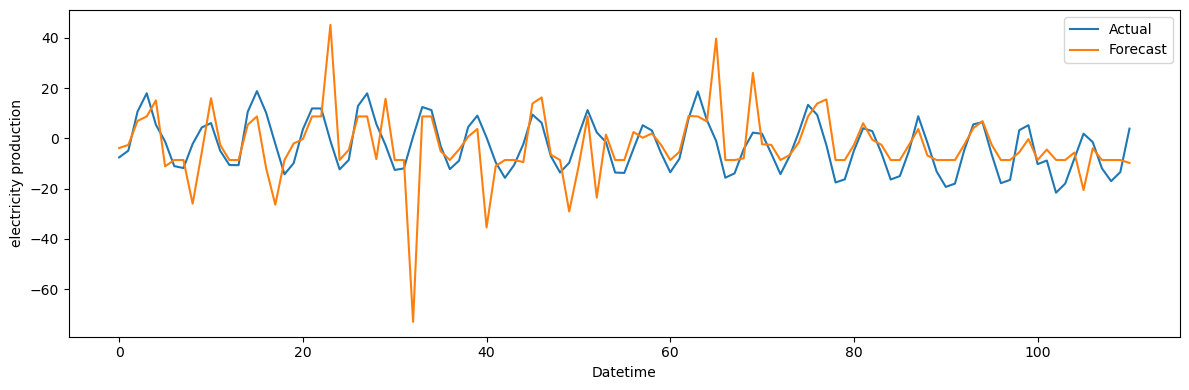

In [27]:
forecast = model(X_test)
plot_forecast((forecast.reshape(111, 1)).detach().numpy(), "LSTM")

The results of the LSTM are much better then those of the RNN. Although it's not excatly the same, the forecast look much like the actual values and it becomes clear that the long term memory of the LSTM comes in handy for time series forecasting.

## Conclusion

In these two notebooks I experimented with time series forecast using deep learning. Seen as the goal is to forecast sequential data, I used an RNN and an LSTM and compared their results. The RNN which only relies on short term memory did an okay job but getting the average price everytime, while on the other hand the LSTM which makes use of long term memory as well did a much better job and was able to approximate the values better.